<a href="https://colab.research.google.com/github/Elisa-Torres/SHTE2023/blob/main/Elisa__StandarizedSelfSupervisedLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow as tf
import os
import time
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive

!wget -q https://git.io/JYx2x -O resnet_cifar10_v2.py
import resnet_cifar10_v2

drive.mount('/content/drive/')
loc = 'drive/MyDrive/Shtem2023/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
os.listdir(loc + 'all_data')

['breastcancerX.npy', 'breastcancerY.npy']

In [ ]:
X = np.load(loc + 'all_data/breastcancerX.npy')

In [ ]:
Y = np.load(loc + 'all_data/breastcancerY.npy')

In [ ]:
X.shape

(979, 300, 300, 3)

In [ ]:
Y[:7]

array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0]])

In [ ]:
Y [-7:]

array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1]])

In [ ]:
np.sum(Y,axis = 0)

array([207, 772])

In [ ]:
X_train = X[:-150]
Y_train = Y[:-150]
Y_val = Y[-150:]
X_val = X[-150:]

In [ ]:
vector = np.random.rand(12)
print(vector)

[0.35520137 0.83334262 0.32817688 0.05589334 0.72744178 0.94097173
 0.56591688 0.22549375 0.48867118 0.38147669 0.39060084 0.07172751]


In [ ]:
vector[:4]

array([0.35520137, 0.83334262, 0.32817688, 0.05589334])

Sourced from https://keras.io/examples/vision/simsiam/

In [ ]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 8 # maybe up to 256
EPOCHS = 15
CROP_TO = 300
SEED = 26
PROJECT_DIM = 128
LATENT_DIM = 64
WEIGHT_DECAY = 0.0005
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [ ]:
Ntrain, Ntest = 32,1024
x_train, y_train, x_test, y_test  = X_train[:Ntrain], Y_train[:Ntrain], X_val[:Ntest], Y_val[:Ntest]
numcat = 2

In [ ]:
### PICTURE EDITING FUNCTIONS

def flip_random_crop(image):
    # With random crops we also apply horizontal flipping.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 3))
    return image


def color_jitter(x, strength=[0.4, 0.4, 0.4, 0.1]):
    x = tf.image.random_brightness(x, max_delta=0.8 * strength[0])
    x = tf.image.random_contrast(
        x, lower=1 - 0.8 * strength[1], upper=1 + 0.8 * strength[1]
    )
    x = tf.image.random_saturation(
        x, lower=1 - 0.8 * strength[2], upper=1 + 0.8 * strength[2]
    )
    x = tf.image.random_hue(x, max_delta=0.2 * strength[3])
    # Affine transformations can disturb the natural range of
    # RGB images, hence this is needed.
    x = tf.clip_by_value(x, 0, 255)
    return x


def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x


def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x


def custom_augment(image):
    # As discussed in the SimCLR paper, the series of augmentation
    # transformations (except for random crops) need to be applied
    # randomly to impose translational invariance.
    image = flip_random_crop(image)
    image = random_apply(color_jitter, image, p=0.8)
    image = random_apply(color_drop, image, p=0.2)
    return image

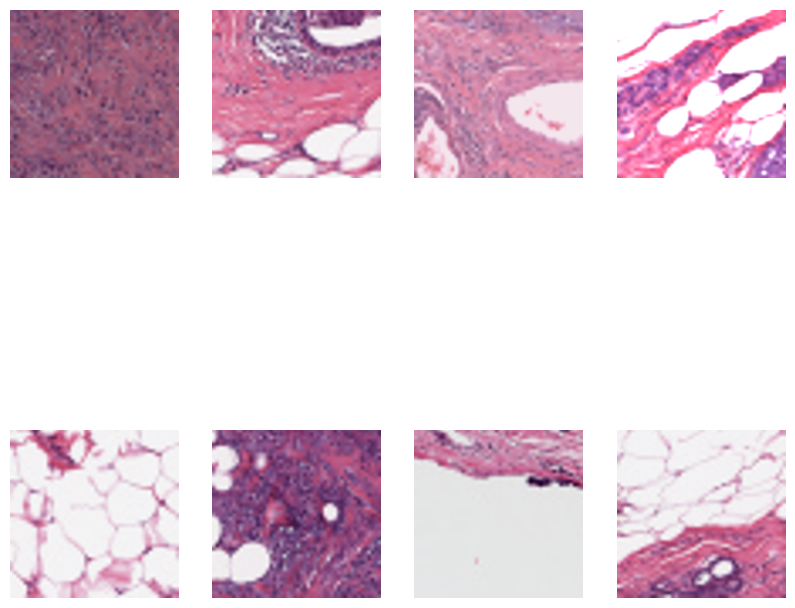

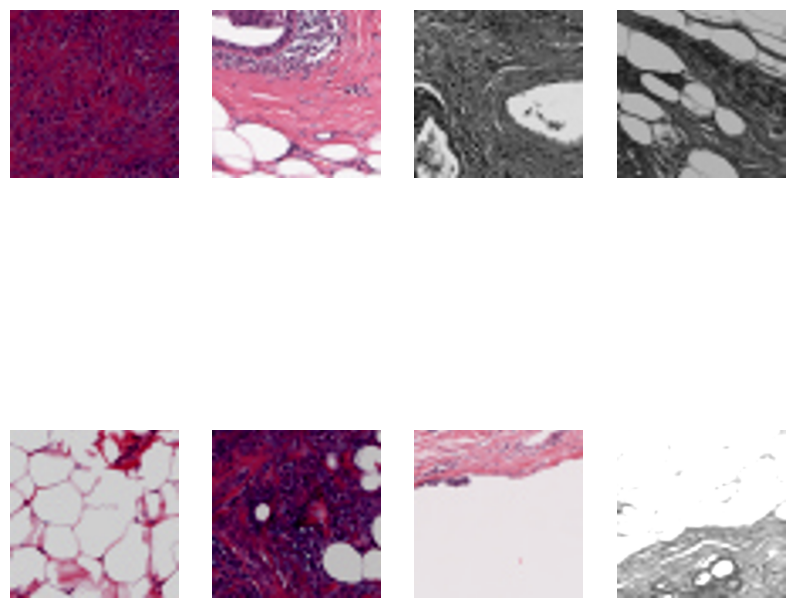

In [ ]:
# 1800 DONT LOOK AT THIS, ITS JUST FANCY MAKING TRAIN SET AND TEST SET

ssl_ds_one = tf.data.Dataset.from_tensor_slices(x_train)
ssl_ds_one = (
    ssl_ds_one.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

ssl_ds_two = tf.data.Dataset.from_tensor_slices(x_train)
ssl_ds_two = (
    ssl_ds_two.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# We then zip both of these datasets.
ssl_ds = tf.data.Dataset.zip((ssl_ds_one, ssl_ds_two))

# Visualize a few augmented images.
sample_images_one = next(iter(ssl_ds_one))
plt.figure(figsize=(10, 10))
for n in range(8):
    ax = plt.subplot(2, 4, n + 1)
    plt.imshow(sample_images_one[n].numpy().astype("int"))
    plt.axis("off")
plt.show()

# Ensure that the different versions of the dataset actually contain
# identical images.
sample_images_two = next(iter(ssl_ds_two))
plt.figure(figsize=(10, 10))
for n in range(8):
    ax = plt.subplot(2, 4, n + 1)
    plt.imshow(sample_images_two[n].numpy().astype("int"))
    plt.axis("off")
plt.show()

In [ ]:
N = 2
DEPTH = N * 9 + 2
NUM_BLOCKS = ((DEPTH - 2) // 9) - 1


def get_encoder():
    # Input and backbone.
    inputs = layers.Input((CROP_TO, CROP_TO, 3))
    x = layers.Rescaling(scale=1.0 / 127.5, offset=-1)(
        inputs
    )
    x = resnet_cifar10_v2.stem(x)
    x = resnet_cifar10_v2.learner(x, NUM_BLOCKS)
    x = layers.GlobalAveragePooling2D(name="backbone_pool")(x)

    # Projection head.
    x = layers.Dense(
        PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dense(
        PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY)
    )(x)
    outputs = layers.BatchNormalization()(x)
    return tf.keras.Model(inputs, outputs, name="encoder")


def get_predictor():
    model = tf.keras.Sequential(
        [
            # Note the AutoEncoder-like structure.
            layers.Input((PROJECT_DIM,)),
            layers.Dense(
                LATENT_DIM,
                use_bias=False,
                kernel_regularizer=regularizers.l2(WEIGHT_DECAY),
            ),
            layers.ReLU(),
            layers.BatchNormalization(),
            layers.Dense(PROJECT_DIM),
        ],
        name="predictor",
    )
    return model

In [ ]:
def compute_loss(p, z):
    # The authors of SimSiam emphasize the impact of
    # the `stop_gradient` operator in the paper as it
    # has an important role in the overall optimization.
    z = tf.stop_gradient(z)
    p = tf.math.l2_normalize(p, axis=1)
    z = tf.math.l2_normalize(z, axis=1)
    # Negative cosine similarity (minimizing this is
    # equivalent to maximizing the similarity).
    return -tf.reduce_mean(tf.reduce_sum((p * z), axis=1))

In [ ]:
class SimSiam(tf.keras.Model):
    def __init__(self, encoder, predictor):
        super().__init__()
        self.encoder = encoder
        self.predictor = predictor
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        # Unpack the data.
        ds_one, ds_two = data

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            z1, z2 = self.encoder(ds_one), self.encoder(ds_two)
            p1, p2 = self.predictor(z1), self.predictor(z2)
            # Note that here we are enforcing the network to match
            # the representations of two differently augmented batches
            # of data.
            loss = compute_loss(p1, z2) / 2 + compute_loss(p2, z1) / 2

        # Compute gradients and update the parameters.
        learnable_params = (
            self.encoder.trainable_variables + self.predictor.trainable_variables
        )
        gradients = tape.gradient(loss, learnable_params)
        self.optimizer.apply_gradients(zip(gradients, learnable_params))

        # Monitor loss.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

4/4 [==============================] - 125s 30s/step - loss: -0.3273


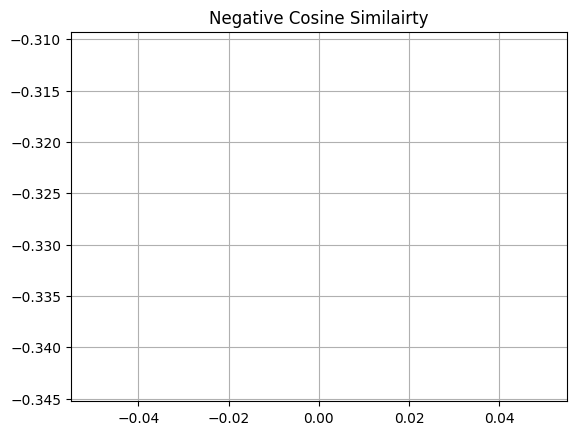

In [ ]:
### SELF LEARNING
EPOCHS = 1
# Create a cosine decay learning scheduler.
num_training_samples = len(x_train)
steps = EPOCHS * (num_training_samples // BATCH_SIZE)
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.03, decay_steps=steps
)

# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss", patience=5, restore_best_weights=True
)

# Compile model and start training.
simsiam = SimSiam(get_encoder(), get_predictor())
simsiam.compile(optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6))
history = simsiam.fit(ssl_ds, epochs=EPOCHS, callbacks=[early_stopping])

# Visualize the training progress of the model.
plt.plot(history.history["loss"])
plt.grid()
plt.title("Negative Cosine Similarity")
plt.show()

In [ ]:
# We first create labeled `Dataset` objects.
#### TESTING PERFORMANCE OF SELF LEARNING WITH LABELS

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Then we shuffle, batch, and prefetch this dataset for performance. We
# also apply random resized crops as an augmentation but only to the
# training set.
train_ds = (
    train_ds.shuffle(1024)
    .map(lambda x, y: (flip_random_crop(x), y), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

# Extract the backbone ResNet20.
backbone = tf.keras.Model(
    simsiam.encoder.input, simsiam.encoder.get_layer("backbone_pool").output
)

# We then create our linear classifier and train it.
backbone.trainable = False # locking self learning in place
inputs = layers.Input((CROP_TO, CROP_TO, 3))
x = backbone(inputs, training=False)
x = layers.Dense(24, activation= "tanh")(x) #add more of these??? maybe change the cell count???
####
####
       # if i was a cientetist i would add layers here maybe, butlike dont go crazy pls
####
####
outputs = layers.Dense(numcat, activation="softmax")(x)
linear_model = tf.keras.Model(inputs, outputs, name="linear_model")

# Compile model and start training.
linear_model.compile(
    loss="categorical_crossentropy",
    metrics=["accuracy"],
    optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.9),
)
history = linear_model.fit(
    train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[early_stopping]
)
_, test_acc = linear_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

4/4 [==============================] - ETA: 0s - loss: 2.1684 - accuracy: 0.6250

KeyboardInterrupt: ignored

In [ ]:
###  TRAINING WITHOUT SELF SUPERVISED LEARNING
selflessNtrain = 100
def self_less_model(indim):
  inputs = layers.Input((indim, indim, 3))
  resnet = tf.keras.Model(
    simsiam.encoder.input, simsiam.encoder.get_layer("backbone_pool").output
  )
  # We then create our linear classifier and train it.
  x = resnet(inputs)
  #add layers here
  outputs = layers.Dense(numcat, activation="softmax")(x)
  linear_model = tf.keras.Model(inputs, outputs, name="linear_model")
  # Compile model and start training.
  return linear_model

self_less = self_less_model(x_train[0].shape[0])
self_less.trainable=True
self_less.summary()
self_less.compile(
    loss="categorical_crossentropy",
    metrics=["accuracy"],
    optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.9),
)

self_less.fit(x_train,y_train, epochs=10)
print(self_less.evaluate(x_test,y_test))

NameError: ignored